# Topic modelling

The goal of this notebook is to run topic modelling on the dataset. For performance reasons we limit ourselves to the Illinois Appellate Court containing approximately 120k documents.

https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#9buildldamodelwithsklearn


In [1]:
import sys
sys.path.append("..")

import json
import pickle
import numpy as np
from pprint import pprint
from collections import defaultdict

import matplotlib.pyplot as plt 

from lda import guidedlda as glda
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation as lda

import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

from src.seeds import Seeds
from src.dataset import Dataset
from src.vectorizers import TokenVectorizer
from src.lda_utils import get_word_relevance, get_words_relevance, print_topics

import warnings
warnings.filterwarnings('ignore')

## Tokens loading and preprocessing

The first step is to load the tokenized documents and to filter the tokens, removing those that are over and under used.

In [2]:
dataset = Dataset()
tokens = dataset.load_dataset(year=None, 
                              fields={"tokens"}, 
                              courts={"Illinois Appellate Court"})

In [3]:
len(tokens)

123915

### Filtering
We count the occurrences of each token and filter those that do not match the criteria.

In [4]:
freq = defaultdict(lambda:0)
for doc in tokens:
    # for w in doc:
    for w in set(doc):        
        freq[w] += 1

In [2]:
seeds = Seeds()

narcotics, weapons, investigation = seeds.get_final_filtered_seeds()

interesting_set = narcotics.union(weapons).union(investigation)
print(f"First five interesting: {list(interesting_set)[:5]}")

First five interesting: ['hallucinogenic', 'molest', 'seconal', 'pill', 'screwdriver']


In [6]:
def sel_criterium(w):
    return (w in interesting_set) or ((len(w) >= 3) and (10 < freq[w] < 0.5*len(tokens)))
    
tokens = [[w for w in doc if sel_criterium(w)] for doc in tokens]

### Vectorization
The next step is to vectorize the data with a count vectorizer. The results are saved on disk to avi having to run the first cells each time, saving RAM.

In [7]:
dv = TokenVectorizer(tokens, method="count")

vectors = dv.vectors()
dv.save_vectors_vectorizer(vectors)
print(f"Vocabulary length: {len(dv.vectorizer.vocabulary_)}")

Vocabulary length: 48480


In [3]:
vectors, vectorizer = TokenVectorizer.load_vectors_vectorizer(method="count")cocaine

## Finding the optimal number of topics (Google colab notebook)

Before proceeding with other models, we find the optimal number of topics with a grid search approach.

In [4]:
lda_model = pickle.load(open("../data/models/IAC_exp_seed_minf_10_max_50%.pk", "rb"))

In [5]:
lda_model.get_params()

{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 14,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': None,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}

### Printing topics words
Here are the found most relevant words for each topic.

In [41]:
print_topics(lda_model, 
             vectorizer, 
             n_top_words=10, 
             only_interesting=False)


Topic: 0
175874.6*testify + 141465.7*people + 137128.4*testimony + 125854.5*jury + 122627.78*witness + 96886.25*statement + 88218.39*tell + 80253.1*defense + 69331.6*victim + 68604.53*counsel

Topic: 1
70381.34*agreement + 69661.76*fee + 55678.37*award + 54902.84*petitioner + 54067.89*attorney + 51296.93*pay + 49045.8*support + 46536.89*marriage + 38157.62*respondent + 37060.48*child

Topic: 2
125065.21*sentence + 120636.55*people + 81434.9*counsel + 77881.66*offense + 76217.87*charge + 75706.18*motion + 67447.62*conviction + 65249.36*section + 63916.08*guilty + 57991.85*criminal

Topic: 3
90761.45*board + 72190.03*commission + 50474.56*employee + 46509.46*claimant + 44530.44*decision + 40754.75*work + 39653.41*department + 35642.4*employment + 35134.44*review + 34746.18*plaintiff

Topic: 4
66326.71*respondent + 23741.21*statement + 23540.52*information + 23092.26*testify + 22208.54*mental + 21102.85*person + 18946.06*check + 16264.99*attorney + 14910.75*conduct + 14722.33*report

Top

### Considering only words of interest
Here are only the words of interest in each topic.

In [42]:
print_topics(lda_model, 
             vectorizer, 
             n_top_words=10, 
             only_interesting=True, 
             interesting_set=interesting_set)


Topic: 0
53908.79*murder + 39440.33*gun + 26929.79*robbery + 21432.54*sexual + 20435.98*fire + 20241.33*death + 19757.87*abuse + 19158.74*kill + 17705.27*detective + 17060.71*assault

Topic: 1
9012.69*abuse + 2441.71*medical + 2403.18*fraud + 1271.57*warrant + 843.75*green + 839.07*death + 713.92*cal + 656.27*alia + 596.87*don + 561.41*discharge

Topic: 2
21405.48*violation + 15021.54*armed + 13881.52*aggravate + 13848.53*murder + 13403.13*burglary + 12097.53*robbery + 11676.06*theft + 9852.96*abuse + 8754.15*discharge + 8023.32*assault

Topic: 3
22844.95*discharge + 8417.76*fire + 6221.12*medical + 5708.31*violation + 1653.77*plant + 1444.88*prescribe + 704.0*green + 547.53*warrant + 524.92*aggravate + 314.37*chemical

Topic: 4
6944.57*sexual + 6162.64*fraud + 4709.32*sexually + 3572.15*abuse + 2987.28*discharge + 2486.97*forgery + 2329.84*sex + 2075.77*medical + 1942.53*psychotropic + 1796.04*violent

Topic: 5
40546.12*medical + 14163.68*abuse + 6556.86*fraud + 4583.26*violation + 4

### Finding most relevant topics given a word, and a list of words
We define two functions that computes the relevance of each topic given a word and a list of words.

In [40]:
vocab = vectorizer.get_feature_names()
word2id = dict((v, idx) for idx, v in enumerate(vocab))

get_word_relevance("cannabis", word2id, vocab, lda_model, normalize=True)

{0: 0.001,
 1: 0.001,
 2: 11.515,
 3: 0.001,
 4: 0.094,
 5: 0.001,
 6: 0.001,
 7: 0.001,
 8: 0.001,
 9: 0.001,
 10: 0.001,
 11: 0.001,
 12: 0.001,
 13: 88.379}

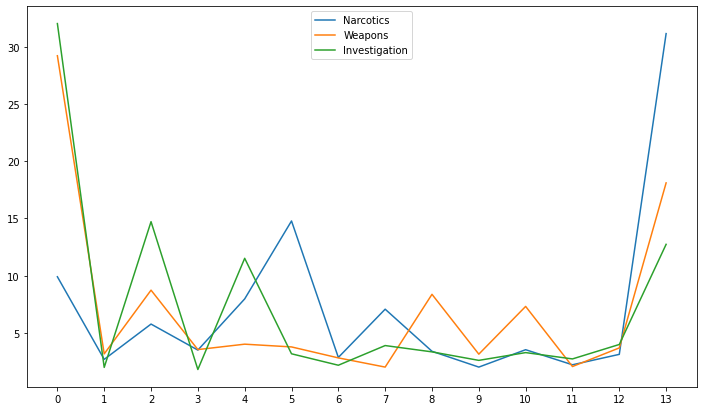

In [9]:
titles = ["Narcotics", "Weapons", "Investigation"]

# for i,l in enumerate([weapons, narcotics, investigation]):
#     print(f"{titles[i]} topics relevance:")
#     data = get_words_relevance(l, word2id, vocab, lda_model, normalize=True)

fig, axs = plt.subplots(1,1, figsize=(12,7))

for i, words in enumerate([narcotics, weapons, investigation]):
    data = get_words_relevance(words, word2id, vocab, lda_model, normalize=True)
    x = list(data.keys())
    y = list(data.values())
    
    # axs[i].set(title=f"{titles[i]} topic distribution", xlabel="Topics", ylabel="%")
    axs.plot(x, y)

plt.legend(titles)
plt.xticks(range(14))

plt.show()

In [23]:
lda_output = lda_model.transform(vectors)

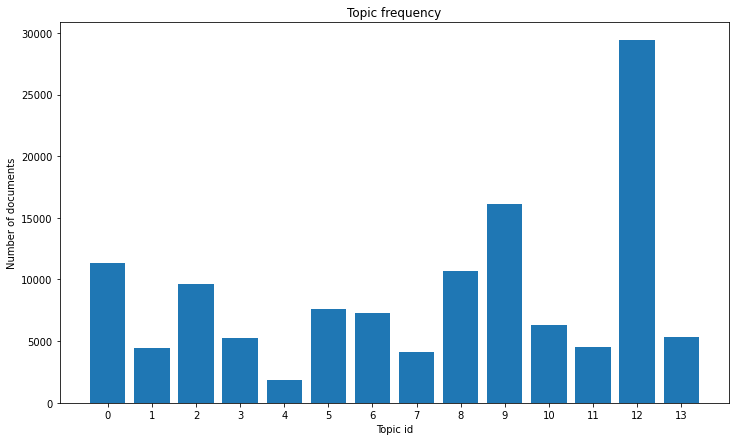

In [34]:
freq = defaultdict(lambda:0)
for e in [np.argmax(row) for row in lda_output]:
    freq[e] += 1
    
x, y = list(freq.keys()), list(freq.values())

fig, axs = plt.subplots(1,1, figsize=(12,7))
axs.bar(x, y)
plt.title("Topic frequency")
plt.xlabel("Topic id")
plt.ylabel("Number of documents")
plt.xticks(range(14))
plt.show()

### Visualization

In [25]:
panel = pyLDAvis.sklearn.prepare(lda_model, vectors, vectorizer)
panel

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.196851 -0.020357       1        1  13.091782
9     -0.152227 -0.069344       2        1   9.030355
5      0.009779  0.040522       3        1   8.890564
8      0.135381 -0.157157       4        1   8.564266
12    -0.025411 -0.183401       5        1   8.464928
2      0.050112  0.107998       6        1   8.193268
10    -0.059559  0.032807       7        1   7.676082
6     -0.096761 -0.006898       8        1   7.603705
13     0.169202  0.002495       9        1   5.842776
7     -0.023438  0.151825      10        1   5.561548
1     -0.092854  0.047040      11        1   5.055782
3     -0.034439  0.077492      12        1   4.395519
11    -0.139351 -0.084934      13        1   3.847530
4      0.062712  0.061910      14        1   3.781894, topic_info=            Term          Freq         Total Category  logprob  loglift
32914  plaintiff  1.133087e+06  1.133087e+06  Default  30.0000  30.0000
1755   appellant  2.371400e+05  2.371400e+05  Default  29.0000  29.0000
1760    appellee  1.723950e+05  1.723950e+05  Default  28.0000  28.0000
30561    officer  2.168330e+05  2.168330e+05  Default  27.0000  27.0000
33168     policy  1.481360e+05  1.481360e+05  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
45633        use  1.036480e+04  2.829212e+05  Topic14  -5.7936  -0.0318
3602     believe  8.702524e+03  1.115638e+05  Topic14  -5.9684   0.7240
8357     concern  8.219200e+03  8.911555e+04  Topic14  -6.0256   0.8915
47649    witness  8.551839e+03  2.141293e+05  Topic14  -5.9859   0.0545
30145       note  8.371597e+03  2.149206e+05  Topic14  -6.0072   0.0295

[1356 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
3         10  0.987376      aabd
142        6  0.996726  absentia
142       10  0.002167  absentia
159        1  0.017258  abstract
159        2  0.157367  abstract
...      ...       ...       ...
48451      8  0.008489    zurich
48451     10  0.021222    zurich
48451     11  0.000531    zurich
48451     13  0.028650    zurich
48451     14  0.000531    zurich

[7575 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 10, 6, 9, 13, 3, 11, 7, 14, 8, 2, 4, 12, 5])

In [29]:
panel = pyLDAvis.sklearn.prepare(lda_model, vectors, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0        1.425140 -203.131439       1        1  13.091782
9       93.696953  -55.018154       2        1   9.030355
5      141.694016   25.320429       3        1   8.890564
8     -126.233505    5.739788       4        1   8.564266
12     -59.868134  101.519302       5        1   8.464928
2      151.966629  133.119141       6        1   8.193268
10      12.542690 -101.441658       7        1   7.676082
6       49.372585   57.773476       8        1   7.603705
13     203.505997  -84.541840       9        1   5.842776
7      119.923477 -166.068970      10        1   5.561548
1      -19.315592   -8.882428      11        1   5.055782
3      -95.841057 -109.373474      12        1   4.395519
11      37.554749  165.057098      13        1   3.847530
4      243.648911   32.733547      14        1   3.781894, topic_info=            Term          Freq         Total Category  logprob  loglift
32914  plaintiff  1.133087e+06  1.133087e+06  Default  30.0000  30.0000
1755   appellant  2.371400e+05  2.371400e+05  Default  29.0000  29.0000
1760    appellee  1.723950e+05  1.723950e+05  Default  28.0000  28.0000
30561    officer  2.168330e+05  2.168330e+05  Default  27.0000  27.0000
33168     policy  1.481360e+05  1.481360e+05  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
45633        use  1.036480e+04  2.829212e+05  Topic14  -5.7936  -0.0318
3602     believe  8.702524e+03  1.115638e+05  Topic14  -5.9684   0.7240
8357     concern  8.219200e+03  8.911555e+04  Topic14  -6.0256   0.8915
47649    witness  8.551839e+03  2.141293e+05  Topic14  -5.9859   0.0545
30145       note  8.371597e+03  2.149206e+05  Topic14  -6.0072   0.0295

[1356 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
3         10  0.987376      aabd
142        6  0.996726  absentia
142       10  0.002167  absentia
159        1  0.017258  abstract
159        2  0.157367  abstract
...      ...       ...       ...
48451      8  0.008489    zurich
48451     10  0.021222    zurich
48451     11  0.000531    zurich
48451     13  0.028650    zurich
48451     14  0.000531    zurich

[7575 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 10, 6, 9, 13, 3, 11, 7, 14, 8, 2, 4, 12, 5])

In [30]:
panel = pyLDAvis.sklearn.prepare(lda_model, vectors, vectorizer, mds='mmds')
panel

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.114046  0.200812       1        1  13.091782
9     -0.233384  0.005942       2        1   9.030355
5     -0.012252  0.031780       3        1   8.890564
8     -0.046482  0.261494       4        1   8.564266
12    -0.157928  0.152911       5        1   8.464928
2      0.191832 -0.009374       6        1   8.193268
10    -0.099322 -0.025920       7        1   7.676082
6     -0.165102 -0.094376       8        1   7.603705
13     0.177468  0.151585       9        1   5.842776
7      0.008848 -0.210580      10        1   5.561548
1     -0.112570 -0.182326      11        1   5.055782
3      0.060607 -0.148964      12        1   4.395519
11     0.171752 -0.178141      13        1   3.847530
4      0.102488  0.045156      14        1   3.781894, topic_info=            Term          Freq         Total Category  logprob  loglift
32914  plaintiff  1.133087e+06  1.133087e+06  Default  30.0000  30.0000
1755   appellant  2.371400e+05  2.371400e+05  Default  29.0000  29.0000
1760    appellee  1.723950e+05  1.723950e+05  Default  28.0000  28.0000
30561    officer  2.168330e+05  2.168330e+05  Default  27.0000  27.0000
33168     policy  1.481360e+05  1.481360e+05  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
45633        use  1.036480e+04  2.829212e+05  Topic14  -5.7936  -0.0318
3602     believe  8.702524e+03  1.115638e+05  Topic14  -5.9684   0.7240
8357     concern  8.219200e+03  8.911555e+04  Topic14  -6.0256   0.8915
47649    witness  8.551839e+03  2.141293e+05  Topic14  -5.9859   0.0545
30145       note  8.371597e+03  2.149206e+05  Topic14  -6.0072   0.0295

[1356 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
3         10  0.987376      aabd
142        6  0.996726  absentia
142       10  0.002167  absentia
159        1  0.017258  abstract
159        2  0.157367  abstract
...      ...       ...       ...
48451      8  0.008489    zurich
48451     10  0.021222    zurich
48451     11  0.000531    zurich
48451     13  0.028650    zurich
48451     14  0.000531    zurich

[7575 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 10, 6, 9, 13, 3, 11, 7, 14, 8, 2, 4, 12, 5])